# Differential genefusion SVs between PCAWG and 1KG

Ideas:

- Use 1kg genefusion evidence to filter out PCAWG results.
- Gene-wise filtering: for each gene, compute the top 95th percentile of fusions in the genefusion count distribution. There is sufficient evidence these genefusions are common in the healthy population
- Population-wise filtering: compute the 95th percentile of normalized count for each gene's genefusion count distribution. Take a distribution of these 95th percentiles. Use the median or 95th percentile imposed on the 95th percentile distribution as filter criteria

## Imports

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import multiprocessing as mp
from functools import partial
import itertools
os.chdir('/data/jake/genefusion/scripts/python')
cpus = 10

In [71]:
gene_file='/data/jake/genefusion/data/gene_file.txt'
df_genes = pd.read_csv(gene_file, sep='\t', header = None)
df_genes.columns = ['chrm', 'start', 'end', 'gene', 'strand']
def gene_location(df_genes, gene):
    gene_row = df_genes[df_genes['gene'] == gene]
    chrm = gene_row['chrm'].values[0]
    start = gene_row['start'].values[0]
    end = gene_row['end'].values[0]
    
    return chrm, start, end
print(gene_location(df_genes, 'OR4F5'))
df_genes.head()

('1', np.int64(69091), np.int64(70008))


,chrm,start,end,gene,strand
0,1,69091,70008,OR4F5,pos
1,1,134901,139379,AL627309.1,neg
2,1,139790,140339,RP11neg34P13.14,neg
3,1,367640,368634,OR4F29,pos
4,1,621059,622053,OR4F16,neg


## 1kg

In [6]:
#dir_pcawg = '/data/jake/genefusion/data/2024_10_31-fusions'
dir_1kg = '/data/jake/genefusion/data/2024_11_01-fusions-1kg'
dir_1kg_fusions = os.path.join(dir_1kg, 'fusions')

In [10]:
os.listdir(dir_1kg_fusions)[0:5]

['1.neg.ZNF669.247263264.247267674.fusions',
 '17.neg.CCL3.34415602.34417515.fusions',
 '20.pos.VAPB.56964178.57026157.fusions',
 '10.pos.RP11neg162G10.5.38146668.38148038.fusions',
 '11.neg.RP5neg901A4.1.67792277.67797928.fusions']

In [145]:
fusionfiles = glob.glob(os.path.join(dir_1kg_fusions, '*.fusions'))
print(len(fusionfiles))
# filter out empty files
fusionfiles = [f for f in fusionfiles if os.stat(f).st_size > 0]
print(len(fusionfiles))

26998
25924


'/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/1.neg.ZNF669.247263264.247267674.fusions'

## ERG (chrm 21 neg)

In [13]:
regex = re.compile('21\\.neg\\.ERG')
regex
for file in os.listdir(dir_1kg_fusions):
    if regex.search(file):
        ergfile = file
try: 
    ergfile
except NameError:
    print('No ERG file found')

In [18]:
df_erg = pd.read_csv(os.path.join(dir_1kg_fusions, ergfile), sep='\t',header=None)
df_erg.columns = ['chrm', 'start', 'end', 'gene', 'strand']
df_erg.head()

,chrm,start,end,gene,strand
0,21,39756323,39756358,ERG,neg
1,21,39756691,39756781,ERG,neg
2,21,39760265,39760366,ERG,neg
3,21,39755190,39755292,ERG,neg
4,21,39753426,39753527,ERG,neg


### Mode

In [27]:
# including self
print(df_erg['gene'].mode())
print(df_erg['gene'].value_counts().max())
# self value
# non-self
print(df_erg['gene'][df_erg['gene'] != 'ERG'].mode())
# mode value
df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().max()

0    ERG
Name: gene, dtype: object
9813
0    DMD
Name: gene, dtype: object


np.int64(111)

### Count ranks and distributions

In [152]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
counts.head()

[ 1.   3.   7.  21.5]


gene
DMD         111
TM4SF2       99
LARGE        78
IL1RAPL1     73
DSCAM        61
Name: count, dtype: int64

[0.         0.47712125 0.84509804 1.35111   ]


[]

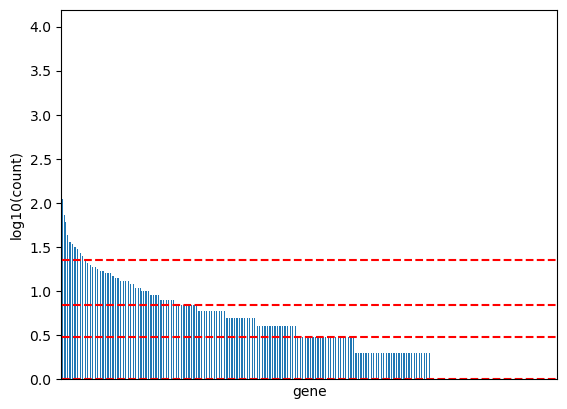

In [153]:
counts = df_erg['gene'].value_counts().apply(lambda x: np.log10(x))
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
ax = counts.plot(kind='bar', )
ax.hlines(y=qs, xmin=0, xmax=counts.shape[0], color='red', linestyle='--')
ax.set_ylabel('log10(count)')
ax.set_xticks([])  
ax.set_xticklabels([]) 

#### >= 95th% counts

In [154]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
counts_95 = counts[counts > qs[3]]
counts_95

gene
DMD          111
TM4SF2        99
LARGE         78
IL1RAPL1      73
DSCAM         61
MTnegND5      53
TTC28         47
SYN3          44
MTnegND4      44
MTnegRNR2     42
DHRSX         36
MTnegCO1      36
NLGN4X        36
FRMPD4        35
MTnegCYB      34
ARHGAP6       34
RBFOX2        33
MTnegCO3      32
PCDH11Y       32
MTnegRNR1     31
FAM19A5       30
CECR2         30
MKL1          30
TBC1D22A      30
TNRC6B        29
EFCAB6        27
NHS           25
MTnegND6      25
PACSIN2       25
REPS2         25
MTnegATP6     24
MTnegND1      24
MTnegND2      23
KIAA1671      23
MID1          22
Name: count, dtype: int64

This is the set we'd like to subtract from PCAWG population

### Mobility tendency

#### 95th percentile

In [63]:
counts_95.index.tolist()[0:5]

['DMD', 'TM4SF2', 'LARGE', 'IL1RAPL1', 'DSCAM']

In [81]:
locations_95 = {}
for gene in counts_95.index:
    locations_95[gene] = gene_location(df_genes, gene)
locations_95 = pd.DataFrame.from_dict(locations_95, orient='index', columns=['chrm', 'start', 'end'])
locations_95.chrm.value_counts()

chrm
22    12
MT    11
X     10
21     1
Y      1
Name: count, dtype: int64

## Population stats

Normalize counts to [0,1] frequencies for comparison across populations

In [151]:
def get_95(fusionfile, normalize=False):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize)\
        .sort_values(ascending=False)
    q = float(np.quantile(counts, 0.95))
    return q
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions')))
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions'), normalize=True))

21.5
0.004821708903341556


In [125]:
%%capture
with mp.Pool(processes=cpus) as pool:
    dist_95 = pool.map(get_95, fusionfiles)
dist_95[0:5]

In [129]:
filt_95 = [x for x in dist_95 if x is not None]
filt_95[0:5]

[2.0, 4.3999999999999915, 8.5, 1.0, 2.0]

In [130]:
pd.Series(filt_95).describe()

count    25924.000000
mean         7.174452
std         22.957931
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max       2563.600000
dtype: float64

In [131]:
pd.Series(filt_95).quantile(0.95)

np.float64(22.0)

- Median of 95th percentile distribution is 4

- 95th of 95th percentile distribution is 22

### Normalized counts

In [134]:
%%capture
normalize = True
with mp.Pool(processes=cpus) as pool:
    get_95_norm = partial(get_95, normalize=normalize)
    dist_95_norm = pool.map(get_95_norm,fusionfiles)
dist_95_norm[0:5]

In [135]:
filt_95_norm = [x for x in dist_95_norm if x is not None]
filt_95_norm[0:5]

[0.0008090614886731392,
 0.030344827586206838,
 0.005286069651741294,
 0.004424778761061947,
 0.0014124293785310734]

In [137]:
pd.Series(filt_95_norm).describe()

count    25924.000000
mean         0.008536
std          0.044347
min          0.000067
25%          0.000509
50%          0.001144
75%          0.003602
max          1.000000
dtype: float64

In [138]:
pd.Series(filt_95_norm).quantile(0.95)

np.float64(0.019417475728155338)

Use the preceeding results as a gene-wise filter for PCAWG.

Example

If a genefusion has a relative frequency of >20% (95th%tile) within its count distribution in the 1000 genomes population, then ignore it in PCAWG population.

#### Gene-wise filtering

In [169]:
def healthy_fusions(fusionfile, q = 0.95, normalize=True):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize).sort_values(ascending=False)
    qp = float(np.quantile(counts, q))
    h_fusions = counts[counts > qp].index.tolist()
    h_fusions = [f'{gene}+{x}' for x in h_fusions]
    return h_fusions
healthy_fusions('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')   

['ERG+DMD',
 'ERG+TM4SF2',
 'ERG+LARGE',
 'ERG+IL1RAPL1',
 'ERG+DSCAM',
 'ERG+MTnegND5',
 'ERG+TTC28',
 'ERG+SYN3',
 'ERG+MTnegND4',
 'ERG+MTnegRNR2',
 'ERG+DHRSX',
 'ERG+MTnegCO1',
 'ERG+NLGN4X',
 'ERG+FRMPD4',
 'ERG+MTnegCYB',
 'ERG+ARHGAP6',
 'ERG+RBFOX2',
 'ERG+MTnegCO3',
 'ERG+PCDH11Y',
 'ERG+MTnegRNR1',
 'ERG+FAM19A5',
 'ERG+CECR2',
 'ERG+MKL1',
 'ERG+TBC1D22A',
 'ERG+TNRC6B',
 'ERG+EFCAB6',
 'ERG+NHS',
 'ERG+MTnegND6',
 'ERG+PACSIN2',
 'ERG+REPS2',
 'ERG+MTnegATP6',
 'ERG+MTnegND1',
 'ERG+MTnegND2',
 'ERG+KIAA1671',
 'ERG+MID1']

In [170]:
%%capture
with mp.Pool(processes=cpus) as pool:
    h_fusions = pool.map(healthy_fusions, fusionfiles)

In [171]:
len(list(itertools.chain.from_iterable(h_fusions)))

3786645

In [174]:
%%capture
with mp.Pool(processes=cpus) as pool:
    partial_healthy_fusions = partial(healthy_fusions, q=0.5, normalize=True)
    h_fusions_med = pool.map(partial_healthy_fusions, fusionfiles)

In [175]:
len(list(itertools.chain.from_iterable(h_fusions_med)))

34375533

## Summary

- 3.8M genefusions filtered out by gene-wise 95th percentile
- 34M genefusions filtered out by gene-wise median